In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def fetch_rendered_html(url, wait_selector=None, wait_time=15):
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument(
        "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    )
    # Todo - Change the path to windows path
    service = Service(r"c:\Users\Nachappa\chromedriver.exe")
    driver = webdriver.Chrome(service=service, options=chrome_options)
    try:
        driver.get(url)
        if wait_selector:
            WebDriverWait(driver, wait_time).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, wait_selector))
            )
        rendered_html = driver.page_source
    except Exception as ex:
        print(ex)
    finally:
        driver.quit()
    return rendered_html

In [10]:
import markdownify
import re
from bs4 import BeautifulSoup

class EmptyExtraction(Exception):
    pass

def remove_ui_blocks_general(text):
    cleaned_lines = []
    skip = False
    
    # keywords that usually indicate UI junk/login/footer
    junk_keywords = [
        'apply now', 'forgot password', 'request reset', 
         '×', 'loading', 'javascript',

        # UI prompts
        "subscribe", "unsubscribe", "notification", "alert", "popup",
        "scroll to","faq","send otp", "resend otp", "password", "create password",
        "change password", "reset password", "confirm password",
        "update your profile", "complete your profile","sign in", "sign up", "logout", "otp",
        "profile is currently under moderation",
        "haven't received otp", "congratulations", "your password has been changed",
        "thank you for subscribing", "don't have an account",
        "character","lowercase","uppercase", "digit","email id","email address",
        

        # Numbers / stats
        "users have visited", "last updated", "toll free", "working hrs"

    ]
    
    for line in text.splitlines():
        stripped = line.strip().lower()
        
        # Skip lines that match UI patterns
        if any(keyword in stripped for keyword in junk_keywords):
            skip = True
            continue
        
        # Stop skipping if line looks like main content (long enough, not just symbols)
        if skip and len(stripped) > 15:
            skip = False
        
        if not skip:
            # Skip empty lines or lines with only symbols (*, +, -)
            if re.match(r'^[\*\+\-\s]+$', stripped):
                continue
            cleaned_lines.append(line)
            skip=True
    
    return "\n".join(cleaned_lines)

def Clean_Markdown(url):
    
    try:
        rendered_html = fetch_rendered_html(url)
    except Exception as e:
        print(f"Error fetching HTML from {url}: {e}")
        return ""

    try:
        soup = BeautifulSoup(rendered_html, "html.parser")
        text_len = len(soup.get_text(strip=True))
        if text_len < 50:  # threshold you decide
            raise EmptyExtraction(f"Extraction failed for {url}. HTML content is junk/empty.")
    except EmptyExtraction as e:
        print(e)
        return ""
        
        
    
    try:
        markdown_string = markdownify.markdownify(rendered_html, heading_style='ATX')
    except Exception as e:
        print(f"Failed to convert HTML to Markdown : {e}") 

    
    
    # 1. Remove both markdown images (![...](...)) and links ([...](...))
    
    # Removes
    # ![Seed Fund Need](/static/media/seedfund-need.png)
    # ![](data:image/png;base64,abc123)
    # [](/static/media/Launch.5a3470a4.mp4)
    # [More Details](/about)
    link_pattern = r"""
        (?:!?\[[^\]]*\]\([^)]*\))   # normal markdown image/link: [text](url) or ![alt](url)
      | (?:\]\([^)]*\))             # broken shorthand: ](url)
    """
    removed_link = re.sub(link_pattern, "", markdown_string,flags=re.VERBOSE)
    
    
    # 2. Remove Footer
    footer_keywords = [
            "About", "Help", "Join", "Subscribe", "Follow",
            "Terms of Use", "Privacy Policy", "Disclaimer", "Copyright"
        ]
    
    footer_pattern =r"\n###### (?:" + "|".join(map(re.escape, footer_keywords)) + r").*"
    
    removed_footer = re.sub(footer_pattern , "", removed_link,flags=re.DOTALL)


    # 3. Remove known UI junk blocks
    ui_block_patterns = [
        r"(?s)please (?:enter|change).*?submit",
        r"(?s)your password must.*?submit",
        r"(?s)notification alert.*?(yes|no)",
        r"(?s)do you really want to logout.*?(yes|no)",
    ]
    for pat in ui_block_patterns:
        removed_ui_junk = re.sub(pat, "", removed_footer, flags=re.IGNORECASE)
    
    
    # 4. Removes Majority of Header, lines with only symbols (*, +, -) and junk words 
    removed_header_junk = remove_ui_blocks_general(removed_ui_junk)

    # 5. Remove numeric/symbol junk lines
    symbol_noise = [
    r"^\s*©.*$",                     # any line starting with ©
    r"^\s*\d{1,3}(?:[,\d]+)*\s*$",   # pure numeric lines
    r"^\s*\d+\s*/\s*\d+\s*$",        # pagination like 3/12
    ]
    removed_numeric_junk = removed_header_junk
    for pat in symbol_noise:
        removed_numeric_junk = re.sub(pat, "", removed_numeric_junk, flags=re.MULTILINE)
    
    
    # 4. Normalize spaces and newlines for cleaner formatting.
    lines = [line for line in removed_numeric_junk.splitlines() if line.strip()]
    completely_cleaned = "\n".join(lines)

    display(set(markdown_string.splitlines()) - set(completely_cleaned.splitlines()))
    return completely_cleaned

In [22]:
import markdown
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer
from pymilvus import connections, Collection, CollectionSchema, FieldSchema, DataType, utility
import re
import uuid
from datetime import datetime




def chunk_by_sections_and_sentences(text):
    """Split text into chunks by headers, with each sentence or numbered list item forming a separate chunk."""
    chunks = []
    current_chunk = ""
    current_header = ""
    lines = text.split('\n')
    sentence_splitter = re.compile(r'(?<=[.!?])\s+')
    list_item_pattern = re.compile(r'^\d+\.\s+.*$')  # Matches '1. Text', '2. Text', etc.

    for i, line in enumerate(lines):
        line = line.strip()
        if not line:
            continue
        # Detect headers
        if line.startswith('#'):
            if current_chunk:
                # Process the current chunk's content
                content = current_chunk[len(current_header)+1:].strip()
                # Check if content is a numbered list
                list_items = []
                current_item = ""
                for content_line in content.split('\n'):
                    if list_item_pattern.match(content_line):
                        if current_item:
                            list_items.append(current_item.strip())
                        current_item = content_line
                    else:
                        current_item += " " + content_line
                if current_item:
                    list_items.append(current_item.strip())
                
                if list_items:
                    # Handle numbered list items
                    for item in list_items:
                        if item.strip():
                            chunks.append(f"{current_header}\n{item.strip()}.")
                else:
                    # Handle non-list content by splitting into sentences
                    sentences = sentence_splitter.split(content) if content else []
                    for sentence in sentences:
                        if sentence.strip():
                            chunks.append(f"{current_header}\n{sentence.strip()}.")
                if not list_items and not content:  # Handle header-only case
                    chunks.append(current_chunk.strip())
            current_header = line
            current_chunk = current_header + "\n"
        else:
            # Add content under the current header
            current_chunk += line + "\n"
            # Check if the current line is a numbered list item
            if list_item_pattern.match(line):
                # Immediately process the list item
                chunks.append(f"{current_header}\n{line.strip()}.")
                current_chunk = current_header + "\n"
            else:
                # For non-list content, process immediately
                content = current_chunk[len(current_header)+1:].strip()
                sentences = sentence_splitter.split(content) if content else []
                if sentences:
                    for sentence in sentences:
                        if sentence.strip():
                            chunks.append(f"{current_header}\n{sentence.strip()}.")
                    current_chunk = current_header + "\n"

    # Append the last chunk
    if current_chunk:
        content = current_chunk[len(current_header)+1:].strip()
        # Check if content is a numbered list
        list_items = []
        current_item = ""
        for content_line in content.split('\n'):
            if list_item_pattern.match(content_line):
                if current_item:
                    list_items.append(current_item.strip())
                current_item = content_line
            else:
                current_item += " " + content_line
        if current_item:
            list_items.append(current_item.strip())
        
        if list_items:
            for item in list_items:
                if item.strip():
                    chunks.append(f"{current_header}\n{item.strip()}.")
        else:
            sentences = sentence_splitter.split(content) if content else []
            for sentence in sentences:
                if sentence.strip():
                    chunks.append(f"{current_header}\n{sentence.strip()}.")
            if not list_items and not content:
                chunks.append(current_chunk.strip())

    return chunks


{'',
 '\t ID](#)',
 '\t Password](#)',
 '\t Settings](#)',
 '\t+ Login',
 '\t+ [![Register bhaskar](/content/dam/invest-india/newhomepage/register-bhaskar.gif)](https://www.startupindia.gov.in/bhaskar/register)',
 '\t+ [Azərbaycan](#)',
 '\t+ [Change Email',
 '\t+ [Change Email ID](#)',
 '\t+ [Change Password](#)',
 '\t+ [Create',
 '\t+ [Dutch](#)',
 '\t+ [English](#)',
 '\t+ [Español](#)',
 "\t+ [O'zbek](#)",
 '\t+ [Privacy',
 '\t+ [Privacy Settings](#)',
 '\t+ [Suomalainen](#)',
 '\t+ [français](#)',
 '\t+ [português](#)',
 '\t+ [Беларус](#)',
 '\t+ [Кыргызча](#)',
 '\t+ [Точик](#)',
 '\t+ [русский](#)',
 '\t+ [Қазақ](#)',
 '\t+ [اردو](#)',
 '\t+ [فارسی](#)',
 '\t+ [کشمیری](#)',
 '\t+ [कोंकणी](#)',
 '\t+ [डोगरी](#)',
 '\t+ [नेपाली](#)',
 '\t+ [बड़](#)',
 '\t+ [मराठी](#)',
 '\t+ [मैथिली](#)',
 '\t+ [संस्कृतम्](#)',
 '\t+ [सिन्धी](#)',
 '\t+ [हिन्दी](#)',
 '\t+ [অসমীয়া](#)',
 '\t+ [বাঙালি](#)',
 '\t+ [মণিপুরী](#)',
 '\t+ [ਪੰਜਾਬੀ](#)',
 '\t+ [ગુજરાતી](#)',
 '\t+ [ନୀୟ](#)',
 '\t+ [தமிழ்

Verifying data types and lengths:
Validated 92 rows. Sample row:
chunk_id: 108ee8fc-9cae-41b3-9651-128110e87d22 (<class 'str'>)
chunk_sequence: 0 (<class 'int'>)
chunk_text: 
PIIT Recognised Startups.... (<class 'str'>)
chunk_embed: length 384 (<class 'list'>)
doc_id: 6f3a103a-9c81-4ef3-9cc4-8b2c756ef2c1 (<class 'str'>)
url: https://www.startupindia.gov.in/ (<class 'str'>)
doc_timestamp: 2025-08-25 01:48:38 (<class 'str'>)

Inserted 92 chunks into Milvus collection 'startup_india_data'.

Sample chunks for verification:
Chunk 13:
#### National Startup Awards
The National Startup Award is a marquee initiative by Startup India, DPIIT, to recognise exceptional startups across India, creating economic impact and larger societal impact..

Chunk 14:
#### National Startup Awards
The National Startup Awards have been pivotal in providing support to some of the most well\-known startups in the Indian ecosystem currently, including unicorns and other high\-impact startups..

Chunk 15:
#### Nation

In [23]:
# Step 4: Retrieve all records (or a limited number)
from pymilvus import connections, Collection, utility
import pandas as pd
print("\n=== Retrieving All Records (Limited to 10) ===")
try:
    results = collection.query(
        expr="chunk_sequence >= 0",  # Simple condition to match all records
        limit=10,  # Limit to avoid overwhelming output; remove or increase as needed
        output_fields=["chunk_id", "chunk_sequence", "chunk_text", "chunk_embed", "doc_id", "url", "doc_timestamp"]
    )
    # Convert to DataFrame for better readability
    df = pd.DataFrame(results)
    print(df[["chunk_id", "chunk_sequence", "chunk_text", "chunk_embed", "doc_id", "url", "doc_timestamp"]])
except Exception as e:
    print(f"Error querying all records: {e}")


=== Retrieving All Records (Limited to 10) ===
                               chunk_id  chunk_sequence  \
0  00d4167b-ca8f-469d-a6e0-2cf462878a81              76   
1  01174f7c-93c4-4d27-9ed7-4fdfa2850925              22   
2  01f3327c-0327-4337-94a2-4bbe85860edd              37   
3  05c548c1-854a-4a24-a868-71820557fc05              38   
4  06144c91-0709-437a-aafd-4ae3dfd1ed5c              61   
5  068654be-6607-4ddf-a851-bd2b3ff4a2a4              63   
6  07159816-090e-491f-a412-6925d776ca6e              82   
7  0a83d3a1-d337-4a8d-9a54-bdd302f01eaa              35   
8  0b1fe0c7-89be-4149-9e8c-8df5501b3c3a              31   
9  0d0d99b2-b60b-4e49-958b-78785ce75938              28   

                                          chunk_text  \
0  ##### Fund of Funds\nA corpus for contribution...   
1  #### Startup India Investor Connect\nStartup I...   
2  ##### MAARG Mentorship\nMentorship, Advisory, ...   
3  ##### MAARG Mentorship\nWith the aim to foster...   
4  #### Seed Fund Sche

In [13]:
print(collection.num_entities)

145


In [20]:
from pymilvus import Collection

Collection("startup_india_data").drop()
print("Collection deleted!")

Collection deleted!


In [36]:
from pymilvus import list_collections

print(list_collections())

['startup_india_data']


{'',
 '\t+ [About Startup India Seed Fund Scheme](/about)',
 '\t+ [English](#)[हिन्दी](#)[অসমীয়া](#)[বাংলা](#)[ગુજરાતી](#)[ಕನ್ನಡ](#)[മലയാളം](#)[मराठी](#)[ଓଡ଼ିଆ](#)[ਪੰਜਾਬੀ](#)[தமிழ்](#)[తెలుగు](#)',
 '\t+ [Gazette Notification PDF](https://www.startupindia.gov.in/content/dam/invest-india/Templates/seedfund-gazette.pdf)',
 '\t+ [Guidelines for Startup India Seed Fund Scheme (English) PDF](https://www.startupindia.gov.in/content/dam/invest-india/Templates/public/Guidelines%20for%20Startup%20India%20Seed%20Fund%20Scheme.pdf)',
 '\t+ [Guidelines for Startup India Seed Fund Scheme (Hindi) PDF](https://seedfundapi.startupindia.gov.in:3535/filestorage/samplefiles/Guidelines_for_Startup_India_Seed_Fund_Scheme_Hindi.pdf)',
 '\t+ [Incubator Portfolios](/portfolio)',
 '\t+ [Startup Portfolios](/startup_portfolio)',
 '![Card Startup](/static/media/startups.fb209613.svg)For Startups1. A startup, recognized by DPIIT, incorporated not more than 2 years ago at the time of application.',
 '![Features o
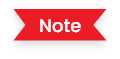

In [33]:
markdown_content = Clean_Markdown('https://seedfund.startupindia.gov.in/')

In [34]:
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from pymilvus import connections, Collection, CollectionSchema, FieldSchema, DataType, utility
import uuid
from datetime import datetime

In [35]:
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from pymilvus import connections, Collection, CollectionSchema, FieldSchema, DataType, utility
import uuid
from datetime import datetime

headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
    ("#####", "Header 5"),
    ("######", "Header 6")
]
markdown_content = Clean_Markdown('https://seedfund.startupindia.gov.in/')
header_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
header_docs = header_splitter.split_text(markdown_content)

sentence_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Max characters per chunk
    chunk_overlap=50,  # Overlap for context
    separators=["\n\n", "\n", ". ", "!", "?", "* "]
)
chunks = []
metadatas = []
doc_id = str(uuid.uuid4())
url = "https://www.startupindia.gov.in/"
doc_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

for i, doc in enumerate(header_docs):
    sub_chunks = sentence_splitter.split_text(doc.page_content)
    header = "\n".join([f"{k}: {v}" for k, v in doc.metadata.items()]) if doc.metadata else ""
    for sub_chunk in sub_chunks:
        chunk_text = f"{header}\n{sub_chunk}".strip() if header else sub_chunk
        chunks.append(chunk_text)
        metadatas.append({
            "chunk_id": str(uuid.uuid4()),
            "chunk_sequence": i,
            "doc_id": doc_id,
            "url": url,
            "doc_timestamp": doc_timestamp
        })

# Step 3: Generate embeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
chunk_embeddings = embeddings.embed_documents(chunks)

# Step 4: Store in Milvus
connections.connect("default", host="localhost", port="19530")
collection_name = "startup_india_data"
if utility.has_collection(collection_name):
    utility.drop_collection(collection_name)

fields = [
    FieldSchema(name="chunk_id", dtype=DataType.VARCHAR, is_primary=True, max_length=36),
    FieldSchema(name="chunk_sequence", dtype=DataType.INT64),
    FieldSchema(name="chunk_text", dtype=DataType.VARCHAR, max_length=65535),
    FieldSchema(name="chunk_embed", dtype=DataType.FLOAT_VECTOR, dim=384),
    FieldSchema(name="doc_id", dtype=DataType.VARCHAR, max_length=36),
    FieldSchema(name="url", dtype=DataType.VARCHAR, max_length=255),
    FieldSchema(name="doc_timestamp", dtype=DataType.VARCHAR, max_length=20)
]
schema = CollectionSchema(fields, "Combined document and chunk metadata")
collection = Collection(collection_name, schema)

# Prepare row-based data
combined_data = [
    {
        "chunk_id": meta["chunk_id"],
        "chunk_sequence": meta["chunk_sequence"],
        "chunk_text": chunk,
        "chunk_embed": embedding,
        "doc_id": meta["doc_id"],
        "url": meta["url"],
        "doc_timestamp": meta["doc_timestamp"]
    }
    for chunk, embedding, meta in zip(chunks, chunk_embeddings, metadatas)
]

collection.insert(combined_data)
collection.create_index(field_name="chunk_embed", index_params={"index_type": "IVF_FLAT", "metric_type": "L2", "params": {"nlist": 128}})
collection.create_index(field_name="doc_id", index_params={"index_type": "TRIE"})
collection.load()

# Step 5: Verify the stored data
print(f"\nInserted {len(chunks)} chunks into Milvus collection '{collection_name}'.")
print("\nSample chunks for verification:")
for i, chunk in enumerate(chunks):
    if "Eligibility Criteria" in chunk or "National Startup Awards" in chunk:
        print(f"Chunk {i+1}:\n{chunk}\n")


Inserted 10 chunks into Milvus collection 'startup_india_data'.

Sample chunks for verification:
Chunk 8:
Header 1: Seed Fund Scheme
Header 2: Eligibility Criteria
For Startups1. A startup, recognized by DPIIT, incorporated not more than 2 years ago at the time of application.
2. The startup must have a business idea to develop a product or a service with a market fit, viable commercialization, and scope of scaling.
3. The startup must have a business idea
For Incubators1. Incubator should be operational for at least two years on the date of application to the scheme.
2. Incubator must have facilities to seat at least 25 individuals.

Chunk 9:
Header 1: Seed Fund Scheme
Header 2: Eligibility Criteria
3. Incubator must have at least 5 startups undergoing incubation physically on the date of application



In [39]:
from pymilvus import list_collections

print(list_collections())

[]


In [38]:
from pymilvus import Collection

Collection("startup_india_data").drop()
print("Collection deleted!")

Collection deleted!


In [29]:
markdown_content = Clean_Markdown('https://seedfund.startupindia.gov.in/portfolio_detail')
 

{'SISFSYou need to enable JavaScript to run this app.'}

In [30]:
markdown_content

''